# RNN (Time Series)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
# %matplotlib notebook
plt.rcParams["figure.figsize"] = (10,6)
# plt.rcParams['figure.dpi'] = 100
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

## Data

Release: Advance Monthly Sales for Retail and Food Services  
Units:  Millions of Dollars, Not Seasonally Adjusted

Frequency:  Monthly

The value for the most recent month is an advance estimate that is based on data from a subsample of firms from the larger Monthly Retail Trade Survey. The advance estimate will be superseded in following months by revised estimates derived from the larger Monthly Retail Trade Survey. The associated series from the Monthly Retail Trade Survey is available at https://fred.stlouisfed.org/series/MRTSSM448USN

Information about the Advance Monthly Retail Sales Survey can be found on the Census website at https://www.census.gov/retail/marts/about_the_surveys.html

Suggested Citation:
U.S. Census Bureau, Advance Retail Sales: Clothing and Clothing Accessory Stores [RSCCASN], retrieved from FRED, Federal Reserve Bank of St. Louis; https://fred.stlouisfed.org/series/RSCCASN, November 16, 2019.

https://fred.stlouisfed.org/series/RSCCASN

In [3]:
df = pd.read_csv('RSCCASN.csv',
                 index_col='DATE',
                 parse_dates=True
                )

In [4]:
df.head()

,RSCCASN
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558


In [5]:
df.info()  # parse_dates=True ve index_col = 'DATE' olmalı. Time Series ile çalışıyorsak bunları yapmak gerek.

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 334 entries, 1992-01-01 to 2019-10-01
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   RSCCASN  334 non-null    int64
dtypes: int64(1)
memory usage: 5.2 KB


In [6]:
df.columns = ['Sales']

In [8]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


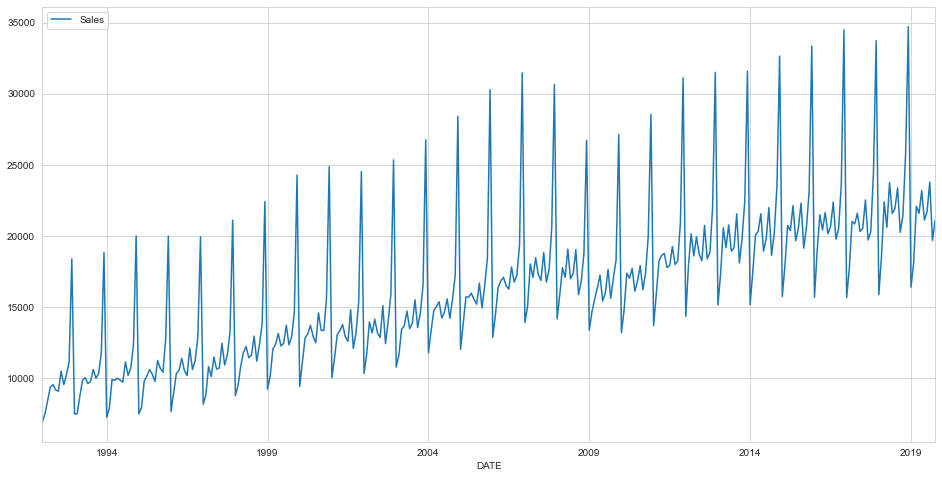

In [9]:
df.plot(figsize=(16,8));

## Preprocessing of Data

### Train Test Split

In [10]:
len(df)

334

In [11]:
len(df)- 18  # 12 (ay) de bir tekrar ediyor data, o yüzden 12 den daha büyük seçmek gerek.

316

In [12]:
test_size = 18

In [13]:
train = 334 - 18
train

316

In [16]:
test_ind = len(df)- test_size
test_ind

316

In [18]:
train = df.iloc[:test_ind]
test = df.iloc[test_ind:]
len(test)

18

In [19]:
train

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2017-12-01,33720
2018-01-01,15881
2018-02-01,18585


In [20]:
test

,Sales
DATE,
2018-05-01,23764
2018-06-01,21589
2018-07-01,21919
2018-08-01,23381
2018-09-01,20260
2018-10-01,21473
2018-11-01,25831
2018-12-01,34706
2019-01-01,16410


### Scaling

In [21]:
from sklearn.preprocessing import MinMaxScaler

In [22]:
scaler = MinMaxScaler()

In [26]:
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

## Time Series Generator

In [27]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [18]:
# help(TimeseriesGenerator)

In [30]:
len(train_scaled), length

(316, 12)

In [31]:
length = 12
generator = TimeseriesGenerator(train_scaled, train_scaled, length = length, batch_size = 1)

In [32]:
generator[0]  # 12 taneden 13. yü tahmin eden ilk datamız bu

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [44]:
X, y = generator[0]  # modelimin istediği, aradığı düzeni oluşturdu. 1 sütun halinde, 12 taneden 1 sonuç çıkardı.
generator[0]

(array([[[0.        ],
         [0.02127505],
         [0.05580163],
         [0.08942056],
         [0.09512053],
         [0.08146965],
         [0.07860151],
         [0.12979233],
         [0.09566512],
         [0.1203892 ],
         [0.15426227],
         [0.41595266]]]),
 array([[0.02047633]]))

In [34]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.         0.02127505 0.05580163 0.08942056 0.09512053 0.08146965
 0.07860151 0.12979233 0.09566512 0.1203892  0.15426227 0.41595266]
Predict this y: 
 [[0.02047633]]


- stride 1 olduğu için 1 kaydırarak yapacak

## Modelling

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [36]:
n_features = 1  # feature sayımız bir, yani bir sütunumuz var.

In [37]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


### EarlyStopping and Validation Generator

In [39]:
from tensorflow.keras.callbacks import EarlyStopping

In [40]:
early_stop = EarlyStopping(monitor = 'val_loss', patience = 5)

In [41]:
validation_generator = TimeseriesGenerator(test_scaled, test_scaled, length = length, batch_size = 1)

In [42]:
len(validation_generator)

6

In [43]:
model.fit_generator(generator, epochs = 20,
                    validation_data = validation_generator,
                    callbacks = [early_stop])

Epoch 1/20
304/304 [==============================] - 6s 12ms/step - loss: 0.0281 - val_loss: 0.0037
Epoch 2/20
304/304 [==============================] - 3s 11ms/step - loss: 0.0196 - val_loss: 0.0191
Epoch 3/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0138 - val_loss: 0.1399
Epoch 4/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0110 - val_loss: 0.0022
Epoch 5/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0060 - val_loss: 0.0013
Epoch 6/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0026 - val_loss: 0.0032
Epoch 7/20
304/304 [==============================] - 2s 5ms/step - loss: 0.0014 - val_loss: 4.0753e-04
Epoch 8/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0012 - val_loss: 8.4098e-04
Epoch 9/20
304/304 [==============================] - 2s 7ms/step - loss: 0.0013 - val_loss: 2.3516e-04
Epoch 10/20
304/304 [==============================] - 3s 10ms/step - loss: 9.4874e-04

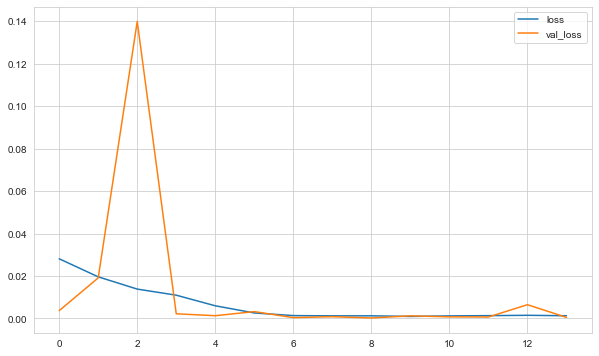

In [45]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot();

## Evaluate on Test Data

In [46]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [47]:
def eval_metrics(actual, pred):
    rmse = np.sqrt(mean_squared_error(actual, pred))
    mae = mean_absolute_error(actual, pred)
    mse = mean_squared_error(actual, pred)
    score = r2_score(actual, pred)
    return print("r2_score:", score, "\n","mae:", mae, "\n","mse:",mse, "\n","rmse:",rmse)

In [48]:
y_pred = model.predict(validation_generator)  # valid generator 18-12 = 6 taneydi
# son 18 taneyi kontrol için ayırdık, ve bu 18 tane içinden stride 1 olacak şekilde 12 ler halinde 6 tane çıktı aldı olay aslında bu.

In [49]:
y_pred

array([[0.6037513 ],
       [0.5356792 ],
       [0.5485594 ],
       [0.5967308 ],
       [0.50086486],
       [0.5403005 ]], dtype=float32)

In [50]:
test_scaled[-6:]

array([[0.59040081],
       [0.51499419],
       [0.53645077],
       [0.61185739],
       [0.46314987],
       [0.51463114]])

In [51]:
eval_metrics(test_scaled[-6:], y_pred)

r2_score: 0.7941484792494118 
 mae: 0.02077584776669225 
 mse: 0.0005104791631091102 
 rmse: 0.022593785940145363


In [52]:
test_predictions = []

first_eval_batch = train_scaled[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)

In [53]:
eval_metrics(test_scaled, test_predictions)

r2_score: 0.9142058657311155 
 mae: 0.032848994224262414 
 mse: 0.0015123046050345716 
 rmse: 0.03888836079130325


### Inverse Transformations and Comparing

In [54]:
true_predictions = scaler.inverse_transform(test_predictions)

In [55]:
test['Predictions'] = true_predictions

In [56]:
test

,Sales,Predictions
DATE,,
2018-05-01,23764,21605.644
2018-06-01,21589,20565.133
2018-07-01,21919,20801.042
2018-08-01,23381,22547.894
2018-09-01,20260,20177.277
2018-10-01,21473,20747.530
2018-11-01,25831,24410.505
2018-12-01,34706,32936.210
2019-01-01,16410,16855.091


<AxesSubplot:xlabel='DATE'>

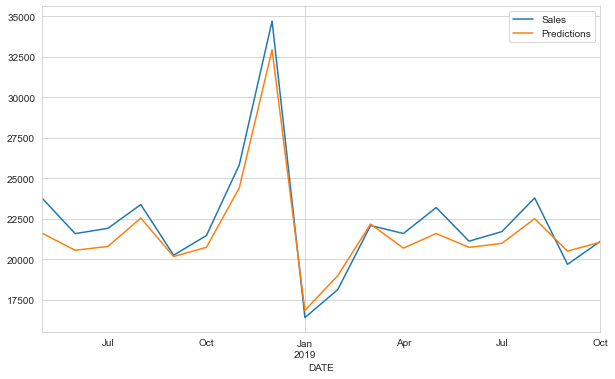

In [57]:
test.plot()

In [58]:
eval_metrics(test.Sales, test.Predictions)

r2_score: 0.9142058657311153 
 mae: 904.7926969130853 
 mse: 1147343.0625232968 
 rmse: 1071.141009635658


## Retrain and Forecasting

In [59]:
full_scaler = MinMaxScaler()
scaled_full_data = full_scaler.fit_transform(df)

In [60]:
length = 12 
generator = TimeseriesGenerator(scaled_full_data, scaled_full_data, length = length, batch_size = 1)

In [61]:
model = Sequential()
model.add(LSTM(100, activation = 'relu', input_shape = (length, n_features)))
model.add(Dense(1))
model.compile(optimizer = 'adam', loss = 'mse')

model.fit_generator(generator, epochs=15)

Epoch 1/15
322/322 [==============================] - 6s 11ms/step - loss: 0.0231
Epoch 2/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0175
Epoch 3/15
322/322 [==============================] - 4s 11ms/step - loss: 0.0086
Epoch 4/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0048
Epoch 5/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0022
Epoch 6/15
322/322 [==============================] - 4s 12ms/step - loss: 0.0021
Epoch 7/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0016
Epoch 8/15
322/322 [==============================] - 4s 13ms/step - loss: 0.0014
Epoch 9/15
322/322 [==============================] - 3s 10ms/step - loss: 0.0013: 0
Epoch 10/15
322/322 [==============================] - 4s 11ms/step - loss: 0.0012
Epoch 11/15
322/322 [==============================] - 3s 10ms/step - loss: 9.3055e-04
Epoch 12/15
322/322 [==============================] - 4s 11ms/step - loss: 0.0012 ETA: 0

In [62]:
scaled_full_data.shape

(334, 1)

In [63]:
scaled_full_data[-length:].shape

(12, 1)

In [64]:
forecast = []
# Replace periods with whatever forecast length you want
periods = 12

first_eval_batch = scaled_full_data[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(periods):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    forecast.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis = 1)

In [65]:
forecast = scaler.inverse_transform(forecast)

In [66]:
forecast

array([[25135.51698065],
       [33119.6936307 ],
       [16530.09379482],
       [18141.93718553],
       [21300.89221382],
       [20980.59493208],
       [22412.29972982],
       [20623.73258686],
       [21163.1181674 ],
       [23024.08650017],
       [19420.29100966],
       [20713.52647972]])

In [67]:
df

,Sales
DATE,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


In [68]:
forecast_index = pd.date_range(start = '2019-11-01', periods = periods, freq = 'MS')  # arange in date için yapılanı
#  2019-11-01 den sonra period kadar yukarıda belirtildi (12 tane), ve frekans aralığında (MS months yani aylar halinde) indexler oluştur.

https://stackoverflow.com/questions/35339139/what-values-are-valid-in-pandas-freq-tags

In [69]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [70]:
forecast_df = pd.DataFrame(data = forecast, index = forecast_index, columns = ['Forecast'])

In [71]:
forecast_df

,Forecast
2019-11-01,25135.517
2019-12-01,33119.694
2020-01-01,16530.094
2020-02-01,18141.937
2020-03-01,21300.892
2020-04-01,20980.595
2020-05-01,22412.300
2020-06-01,20623.733
2020-07-01,21163.118
2020-08-01,23024.087


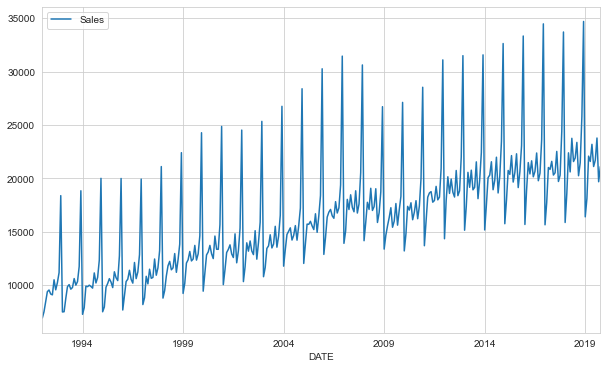

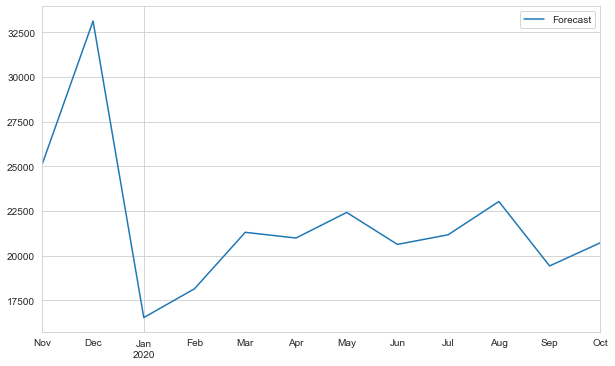

In [73]:
df.plot()
forecast_df.plot();

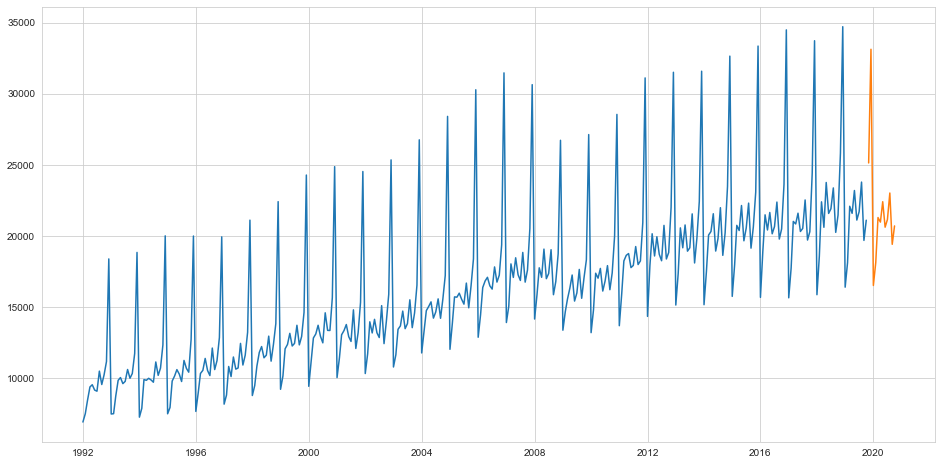

In [74]:
# arka arkaya çıkması için 1.yol
plt.figure(figsize = (16, 8))
plt.plot(df.index, df['Sales'])
plt.plot(forecast_df.index, forecast_df['Forecast']);
#plt.plot(forecast_index, forecast)

### Joining pandas plots

https://stackoverflow.com/questions/13872533/plot-different-dataframes-in-the-same-figure

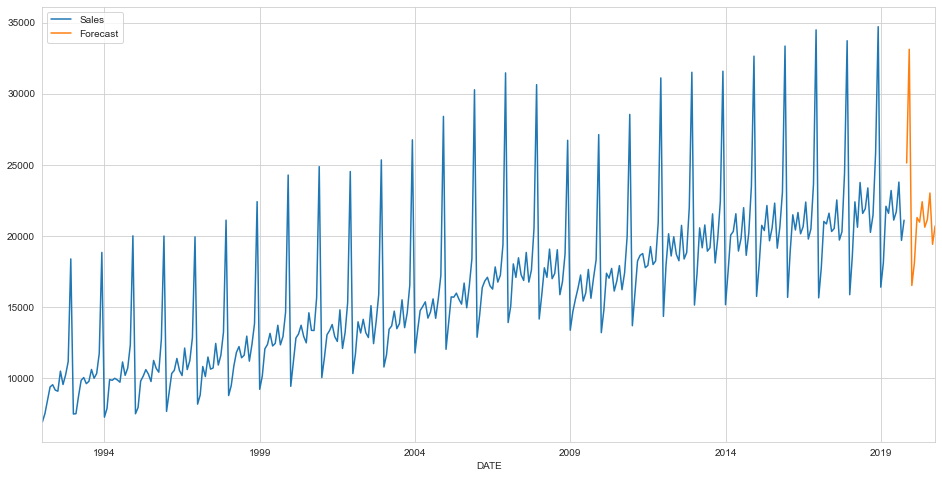

In [75]:
# arka arkaya çıkması için 2. yol.
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8));

(576.0, 611.0)

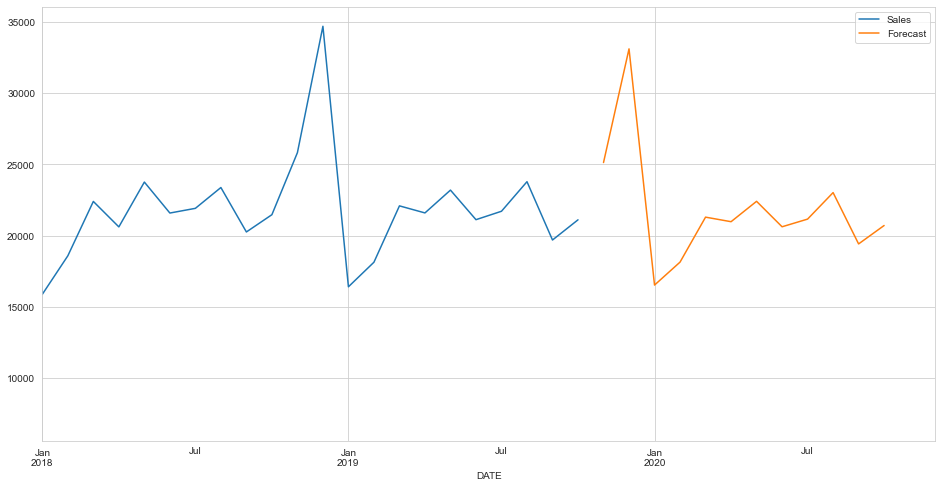

In [76]:
# bu şekilde editleyebiliriz.
ax = df.plot()
forecast_df.plot(ax = ax, figsize = (16, 8))
plt.xlim('2018-01-01', '2020-12-01')